# <center> **Spark Task-Dave Webb-20104099**

# **Initialisation of spark**

In [3]:
!apt-get install openjdk-11-jre-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz
!tar zxf spark-3.0.2-bin-hadoop3.2.tgz
!pip3 install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop3.2"

In [5]:
import findspark
findspark.init()

In [6]:
from pyspark import SparkConf, SparkContext
spark_conf = SparkConf().setMaster('local').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)

# **Import of Libraries**

In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
print('libraries imported')

libraries imported


# **Define Useful Functions**

Useful functions defined by Luciano in class to help tidy up code when searching RDDs.

In [8]:
json2dict = lambda x: json.loads(x)

In [9]:
def slice_dict(my_dict, keys): 
    """`my_dict` is a dictionary, and `keys` is assumed to be a list of
    keys that belong to `my_dict`; the sub-dictionary associated with
    `keys` is returned"""
    return { k: v for k, v in my_dict.items() if k in keys }

In [10]:
def merge_dict(d1, d2):
    return { **d1, **d2 }

# **Introduction**

Venue rate and review websites such as yelp.com have been both a blessing and a curse for businesses.  Research has shown that a one star increase in overall rating for a restaurant can lead to a 5-9 % rise in revenue, with the impact of such websites particularly pronounced for independent businesses. (Luca, 2011)  Other research however has shown that it is an industry very open to fraud and nefarious tactics, with evidence of businesses posting fake positive reviews to support themselves and fake negative reviews to hurt their rivals. (Luca and Zervas, 2016)  In such a hard landscape it can prove difficult for businesses to accurately assess their online ratings and place priority on which reviews should be used to guide changes to build/sustain customer reputation, meaning exploration and interpretation of the data collated at yelp can provide a valuable resource.


This report details the exploration of the yelp academic dataset made publicly available on the yelp website (https://www.yelp.com/dataset).  Actual data for the report was supplied by the course tutor obtained from this website for consistency amongst the class, and in accordance with the license agreement all personally stored data is to be deleted once the report is submitted.  The dataset itself contains 6 individual JSON files containing business, check in, photo, review and tip data respectively from yelp.com.  Each of the JSON files contains relevant data to the content of the file with each instance designated its own primary key.  Each JSON file also contains foreign keys to allow interaction between the datasets, these are typically centred on business, and user IDs.


This report shall be broken down into two main sections.  The initial section details some direct queries on the dataset set by the course tutor to assess the structure and processability of the data.  Each of the queries is set out as a question with an accompanying section detailing how the query will be approached.  Where appropriate a brief assessment of the data is also provided as a conclusion.  Section two details a more open exploratory question on the data and as such contains a more detailed introduction justifying the choice of the exploration and a comprehensive analysis and conclusion of the findings for the reader.


<font size='1'>
Luca, M., 2011. Reviews, Reputation, and Revenue: The Case of Yelp.Com. SSRN Electron. J. https://doi.org/10.2139/ssrn.1928601
<br>
<font size='1'>
Luca, M., Zervas, G., 2016. Fake It Till You Make It: Reputation, Competition, and Yelp Review Fraud. Manag. Sci. 62, 36.


# **Import of Data Sets**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
bus_rdd = (sc.textFile('/content/drive/My Drive/yelp/business.json')
  .map(json2dict))

In [13]:
rev_rdd = (sc.textFile('/content/drive/My Drive/yelp/review.json')
  .map(json2dict))

In [14]:
user_rdd = (sc.textFile('/content/drive/My Drive/yelp/user.json')
  .map(json2dict))

# **Section One: Data Query Examples**

## 1. Which reviews have been rated as useful by more than 30 users and funny by more than 20 users? Obtain total number and show a couple of example instances (i.e., use first or take).

Problem approached as follows:
 - review list rdd filtered to instances with >20 funny ratings
 - resulting list rdd filtered to instances with >30 useful ratings (actually done in the same filter as the above step with an 'and' condition)
 - count the number of instances in the resulting filtered list rdd
 - report the first two instances in the filtered list rdd using the 'take()' action

In [15]:
useful_count = 30
funny_count = 20

count = (rev_rdd.filter(lambda x: x['funny'] > funny_count # filter list to instances with >20 funny ratings
                        and x['useful'] > useful_count) # filter list to instances with >30 useful ratings
                        .count()) # count the number of instances in the filtered list

# print the count and the first two examples
print('The number of reviews is', count, 'that meet the description.')
print('')
print('The first 2 example review entries are:')
print('')
rev_rdd.filter(lambda x: x['funny'] > funny_count and x['useful'] > useful_count).take(2)

The number of reviews is 4011 that meet the description.

The first 2 example review entries are:



[{'business_id': 'upgjUq616Yz1IvAvysDLWA',
  'cool': 40,
  'date': '2017-09-08',
  'funny': 25,
  'review_id': 'und_IbRFr2Rwpizt-kfZuw',
  'stars': 5,
  'text': 'Great food!\n\nThis restaurant isn\'t located on the Strip... this place isn\'t Hash House A Go Go, Momofuku, Wicked Spoon nor is it Eggslut (although I\'ve bookmarked those places for future visits) but because of that it doesn\'t have the food prices you pay when dining at the Strip. Get it? For a little over $20 we were able to fill our tummies with delicious food.\n\nI had Ely\'s Burger. Beef, cheese, grilled onions, mushrooms, lettuce, tomato and mayo... hold the pickles and red onion, please. The meal came with crinkle-cut fries. I love the mushrooms in this burger. Tasty and delicious!  Hubby had the Bacon (or Sausage) Skillet. He scarfed it down... no need to ask him if he enjoyed his meal. \n\nThis place has a casual dining atmosphere, nothing fancy. They serve classic American food, breakfast, lunch, and dinner. Grea

## 2. Which businesses based in Las Vegas that are identified as Nightlife have been rated 4.5 stars or higher?

Problem approached as follows:
 - business list rdd filtered to instances where the designated city is 'Las Vegas'
 - resulting list rdd filtered to instances where the designation 'Nightlife' is contained within the '*categories*' section
 - resulting list rdd filtered to instances where the business star rating is => 4.5
 - count the number of instances in the resulting filtered list rdd
 - map to '*business_id*' and '*name*' and report the first ten instances in the filtered list rdd using the 'take()' action (too many businesses to report all in a readable list)

In [23]:
cat = 'Nightlife'
city = 'Las Vegas'
rating = 4.5

# filters run on seperate lines for clairity, can also use and seperator within a filter if required

count = (bus_rdd.filter(lambda x: x['city'] == city) # filter to businesses in 'Las Vegas'
  .filter(lambda x: cat in x['categories']) # filter to businesses categorised as 'Nightlife'
  .filter(lambda x: x['stars'] >= rating) # filter to businesses with => 4.5 star rating
  .count())

print('The number of businesses is', count, 'that meet the description.')
print('')
print('The first 10 example business entries are:')
print('')
(bus_rdd.filter(lambda x: x['city'] == city)
  .filter(lambda x: cat in x['categories'])
  .filter(lambda x: x['stars'] >= rating)
  .map(lambda x: slice_dict(x, ['name', 'business_id'])) # mapped to business_id and name for simplicity when viewing results
  .take(10))

The number of businesses is 382 that meet the description.

The first 10 example business entries are:



[{'business_id': 'WfB_SsYeKy83QQsqAAyGVQ', 'name': 'Cancun Bar & Grill'},
 {'business_id': 'OWbm2cGjhX3CwmqzUJeLoQ', 'name': 'Strip Gun Club'},
 {'business_id': '0Yeb_P24sj6MwG2qmuehkA', 'name': "Till's Bar"},
 {'business_id': 'aRV-V3RXVk9c5YPSNyNjzA', 'name': 'Kahunaville O2 Bar'},
 {'business_id': 'Y3mYtN9A_BPiz3DHX8868A', 'name': 'Speed Zone Tavern'},
 {'business_id': 'etiXHEc6OYEyUTU3orIz6g', 'name': 'EMC Las Vegas'},
 {'business_id': 'iFCz-xI7CV98fcaB4Chh3g', 'name': 'The Black Sheep'},
 {'business_id': 'GGvjkKM74UnOh2NyvwTLZQ', 'name': 'Jjanga Fusion Pocha'},
 {'business_id': 'RpZMz6m-BvUjWOjgN_5_Tw', 'name': 'Wayfarer Bar'},
 {'business_id': '7hpcxyY0azlVtwAlg9N-wA', 'name': 'retroscena'}]

While a simple list of the business which are classified nightlife and rated 4.5 star is not particularly informative in itself it can lead to greater insights on those businesses with further data exploration.  An analysis of the other category features in the list could lead to further insight into the business types on the list, for example in the brief list presented above we can see several business names with 'bar' in the title, indicating that these venue types may be a significant portion of the selected data.  Additionally there may be scope to look into some of the reviews on the venues via nlp methods to see if any trends can be identified in customer feedback on the venues.  Analyses such as this would be particularly useful to anyone looking to establish a business in Las Vegas, providing them with insight on which businesses tend to be the most popular with customers in the area.

## 3. What are the top-10 reviewers, in terms of the absolute number of reviews marked as useful by other users, of Nightlife businesses in Urbana-Champaign?

Problem approached as follows:
 - business list rdd is filtered to businesses in Urbana and Champaign only with the business ID defined as the rdd key and the business ID reserved
 - review list is filtered to reviews that have at least one useful hit, with the business ID defined as the rdd key and the user ID reserved
 - the two lists are inner joined on the business ID key
 - the user ID is extracted and instances of recurring IDs counted (indicating the absolute number of useful reviews posted in Urbana-Champaign)
 - the counted user IDs are ranked and the top 10 presented (along with count number)

**NB: User ID chosen to identify the top 10 reviewers as user name may not be unique**

In [17]:
cat = 'Nightlife'
city = ['Champaign', 'Urbana']

print("The top 10 user IDs that fit the criteria (with corresponding review counts) are:")
print("")

(
  (
      bus_rdd
  .filter(lambda x: cat in x['categories']) # filter to 'Nightlife' businesses
  .filter(lambda x: city[0] in x['city'] or city[1] in x['city']) # filter to businesses in Urbana-Champaign
  .map(lambda x: slice_dict(x, ['business_id'])) # pull out business id and city
  .keyBy(lambda x: x['business_id']) # set business id as the key
  ).join( # filtered business and review rdd lists joined (inner) on the 'business_id' key
      rev_rdd
  .filter(lambda x: x['useful'] > 0) # filter to useful reviews
  .keyBy(lambda x: x['business_id']) # set business id as the key
  .mapValues(lambda x: slice_dict(x, ['user_id'])) # pull out business and user ids
  ).map(lambda x: (x[1][1]['user_id'], 1)) # extract the user ids from the joined list, add a count marker in the tuple
  .reduceByKey(lambda x,y: x+y) # collect the data by user id and count the occurences
  .sortBy(lambda x: x[1], ascending=False) # sort the user ids by the number of occurences in descending order
  .take(10) # take the top 10 occuring user ids
)

The top 10 user IDs that fit the criteria (with corresponding review counts) are:



[('qmjoMFMZdLH69_6eGTGDZw', 22),
 ('nqMG01GBhD381FKn0hixow', 20),
 ('VVimjPD7f8O5D1fhy5vSpw', 20),
 ('Rg3C1gCJsyshSpp-35HLbQ', 19),
 ('GxkY7BqazkQu6I9HBDpbqQ', 19),
 ('pJyV8I6JsKG_iSzPLvb5AA', 19),
 ('xN-xoLhTHUFfTS_BMGG0xg', 17),
 ('pFRE2mNCQvx9DUU542c6Dw', 16),
 ('z_9oeZ5aN8g8AzPNENht8w', 15),
 ('IxiVty8zfZC093jiaFaG3A', 13)]

This list essentially details the most influential reviewers in the Urbana-Champaign area, as other users considered a higher number of their reviews useful than others in the cities.  This could prove a valuable resourse to businesses in the Urbana-Champaign are who are looking to expand or grow their reputation by providing them with a list of influential people in the area to reach out to and provide a marketing platform.  Directed marketing in such a manner may also provide a cheaper more pricise option than a general marketing campaign in the area.

# **Section 2: Exploratory Data Science Question**

## Introduction



For businesses to make a reasonable assessment of their reviews yelp has some additional granularity to its review system for businesses and consumers to take advantage of.  Two of these features are of particular importance:

1.	The ‘elite’ status system (https://www.yelp-support.com/article/What-is-Yelps-Elite-Squad?l=en_GB), where reviewers are given special status depending on the depth of their reviews, profile completion and community interaction, assuring another user that the reviewer is genuine and most likely not computer generated.
2.	The ‘useful’ rating where other yelp users can tag a review as useful when they have assessed which businesses to patronise.

These features allow a business to gauge which reviews are the most influential on customers allowing them to take action.  The issue however is that once a status has been deemed useful by other users it may be too late for a business to react, so what can businesses do to get ahead of the curve?  














## Aim

This aim of this study is to assess the landscape of yelp reviews to see which type of reviews other users find useful, or more specifically **Which star ratings do Yelp users find the most useful, from elite and non-elite reviewers?**  Where a useful review is one which has received at least tag of useful form another yelp user, and an elite reviewer is a user which has achieved elite status at least once in their history on yelp.

Two major stakeholders are identified as the targets of this report:


1.   Business owners who will have a resource indicating which reviews are most likely to be considered useful by potential customers, defined by the elite status of the reviewer and the subsequent rating of the review
2.   Yelp users looking for businesses to patronize who can assess whether ratings are genuine or just part of the general landsape of yelp reviews




## Data Exploration and Analysis

For the data exploration section of the report the data in the yelp rdds will be reduced to just one city, in this case Toronto.  This is done for a couple of reasons, namely to reduce the dataset to a manageable size and reduce data processing times, and to negate any regional variation we may see in the data from different cities and countries.  Whilst out of the scope of this report for the sake of brevity further investigation into any regional variation of user behaviour may also provide a useful and interesting study.

To explore the question first the data must be reduced to an rdd containing only the relevant information combined from the appropriate different master rdds.  This is done in the code cell below as follows:	 
 - Map the **user rdd** to ‘*user_id*’ and ‘*elite*’ status history data only and set the rdd key to ‘*user_id*’
 - Set the key of the **review rdd** to ‘*user_id*’ and map to ‘*business_id*’, ‘*stars*’ rating and ‘*useful*’ tag count data only
 - Inner join the mapped **user** and **review rdd**s on the ‘*user_id*’ keys
 - Merge the data in the joined rdd into one dictionary for simplicity and then reset the key to ‘*business_id*’
 - Filter the **business rdd** to the businesses in the Toronto area
 - Map the filtered **business rdd** to just the ‘*business_id*’ data and also set the key to the ‘*business_id*’
 - Inner join the mapped **user/review combined** and filtered **business rdd**s on the ‘*business_id*’ keys
 - Map the final **combined rdd** to contain the ‘*stars*’ rating, ‘*useful*’ tag count and ‘*elite*' status history
 - This will leave an rdd with rating, usefulness of reviews and the elite status history of the reviewer for businesses in Toronto only (saved as Toronto_revs)


In [18]:
# create list of reviews from users only of Toronto businesses

Toronto_revs_rdd = (
  (
      user_rdd # select user rdd
  .map(lambda x: slice_dict(x, ['user_id','elite'])) # map to 'user_id' data
  .keyBy(lambda x: x['user_id'])
  ).join( # join (inner) filtered user and review rdds on the 'user_id' key
      rev_rdd # select review rdd
  .keyBy(lambda x: x['user_id']) # key by 'user_id'
  .mapValues(lambda x: slice_dict(x, ['business_id', 'stars', 'useful'])) # map to 'business_id', 'stars' and 'useful' counts data
  ).map(lambda x: merge_dict(x[1][0], x[1][1])) # merge joined dictionaries into one for simplicity
  .keyBy(lambda x: x['business_id']) # change data key to 'business_id'
  .mapValues(lambda x: slice_dict(x, ['stars', 'useful', 'elite'])) # map to 'stars', 'useful' count and 'elite' status history data for use
  .join( # join (inner) the filtered business rdd and the previous combined rdd on the 'business_id' key
        bus_rdd # select business rdd
 .filter(lambda x: x['city'] == 'Toronto') # filter to 'Toronto' businesses
 .map(lambda x: slice_dict(x, 'business_id')) # map to 'business_id' data
 .keyBy(lambda x: x['business_id']) # key by 'business_id'      
  ).map(lambda x: x[1][0]) # map to 'stars', 'useful' count and 'elite' status data required for question
)

With a combined rdd of relevant data in place it can now be analysed.  Initial exploration of the data looks at the difference in review ratings between elite and non-elite users to see if there is any difference in behaviour.  This is done via the creation of a bar plot comparing the percentage of reviews given in the Toronto area at each of the potential star ratings for both user groups.  The visualisation is prepared in the code cell below as follows:
-	Filter **Toronto_revs** rdd to the users with no history of elite status (done by selecting those with an '*elite*' status list length == 0)
-	Count the number of reviews from non-elite users and store the number as a variable
-	Map the non-elite user review list to the ‘*star*’ ratings and then reduceByKey to generate a list of the potential ‘*star*’ ratings and the number of occurrences
-	Map an additional calculated column onto the rdd dividing the number of occurrences by the earlier stored count value to generate a percentage figure
-	Repeat these steps for the elite user group (filtered as those with an ‘*elite*’ status list length > 0)
-	Produce a bar plot of the two percentage distributions for comparison


Total number of non-elite user reviews of businesses in Toronto:  273966
Total number of elite user reviews of businesses in Toronto:  157019



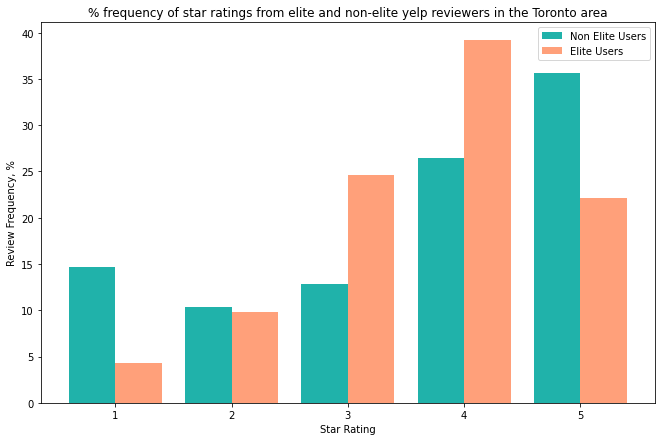

In [19]:
# visualisation of elite/non-elite star rating preferences

# sort and calculate non-elite figures

non_elite_user_count = Toronto_revs_rdd.filter(lambda x: len(x['elite']) == 0).count() # filter to and count the 'non-elite' user reviews

non_elite_user_ratings = (
    Toronto_revs_rdd
  .filter(lambda x: len(x['elite']) == 0) # filter to 'non-elite' user reviews
 .map(lambda x: [x['stars'], 1]) # map to 'star' rating values and add a numeric field to allow reduce functions
 .reduceByKey(lambda x,y: x+y) # reduce the rdd by the 'star' values and count the occurances of each possibility
 .map(lambda x: (x[0], x[1], (x[1]/non_elite_user_count)*100)) # map to the 'star' rating, count and a calculated % of the total count value
)

# sort and calculate elite figures

elite_user_count = Toronto_revs_rdd.filter(lambda x: len(x['elite']) > 0).count() # filter to and count the 'elite' user reviews

elite_user_ratings = (
    Toronto_revs_rdd
 .filter(lambda x: len(x['elite']) > 0) # filter to 'elite' user reviews
 .map(lambda x: [x['stars'], 1]) # map to 'star' rating values and add a numeric field to allow reduce functions
 .reduceByKey(lambda x,y: x+y) # reduce the rdd by the 'star' values and count the occurances of each possibility
 .map(lambda x: (x[0], x[1], (x[1]/elite_user_count)*100)) # map to the 'star' rating, count and a calculated % of the total count value
)

print('Total number of non-elite user reviews of businesses in Toronto: ', non_elite_user_count)
print('Total number of elite user reviews of businesses in Toronto: ', elite_user_count)
print('')

# visualise the results

x = non_elite_user_ratings.map(lambda x: x[0]).collect()
y = non_elite_user_ratings.map(lambda x: x[2]).collect()
z = elite_user_ratings.map(lambda x: x[2]).collect()
w = 0.4

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111)
plot1 = ax.bar(np.array(x)-(w/2), y, width=w, color='LightSeaGreen', align='center')
plot2 = ax.bar(np.array(x)+(w/2), z, width=w, color='LightSalmon', align='center')
ax.set_title('% frequency of star ratings from elite and non-elite yelp reviewers in the Toronto area')
ax.set_xlabel('Star Rating')
ax.set_ylabel('Review Frequency, %')
ax.legend((plot1[0], plot2[0]), ('Non Elite Users', 'Elite Users'));

Key observations from the data are:
-	Negative reviews (1 and 2 star) are far less common that positive reviews (4 and 5 star)
  -	25% of non-elite user reviews negative versus 61% positive
  -	14% of elite user reviews negative versus 62% positive
-	Elite users (most reviews 4 star) tend to be more conservative in their reviews than non-elite users (most reviews 5 star)
-	Non-elite users are more likely to give extreme reviews than elite users, in particular extreme negative reviews
  -	~1.6x more likely to give 5 stars and ~3.7x more likely to give 1 star

These observations suggest that elite reviewers have a far more measured approach than non-elite reviewers when evaluating businesses.  The fact that non-elite reviewers are likelier to give extreme reviews suggests that casual users tend to review more when having a really positive or negative experience, while elite reviewers will provide an opinion for all levels of experience and are more selective when allocating high praise or criticism.  Also the small number of extreme negative reviews from elite users mean these ratings should hold extra emphasis for business owners due to the apparent reluctance for these users to issue such a review.


For the next stage of the analysis we will now examine the usefulness of the reviews from the different user types, classed as the percentage of reviews tagged as useful by at least one other user.  Again the reviews will be segmented by their rating to allow deeper analysis on which type of reviews in the Toronto area are classed as useful by yelp users, with the results presented in a bar chart.  The visualisation is prepared in the code cell below as follows:
-	Filter the **Toronto_revs** rdd to the users with no history of elite status (done by selecting those with an '*elite*' status list length == 0)
-	Filter a separate instance of the Toronto_revs rdd to users with no history of elite status ***and*** where the review has been tagged as '*useful*' by at least one other user
-	Map both rdds to only the ‘*star*’ rating values and apply reduceByKey to generate a list of the potential ‘*star*’ ratings and the number of occurrences
-	Inner join the two rdds using the ‘*star*’ rating as the key
-	Finally map a calculated field onto the joined rdd dividing the useful number of ratings for each potential ‘*star*’ value by the total number to create a percentage
-	Repeat these steps for the elite user group (filtered as those with an ‘*elite*’ status list > 0)
-	Produce a bar plot of the two percentage distributions for comparison


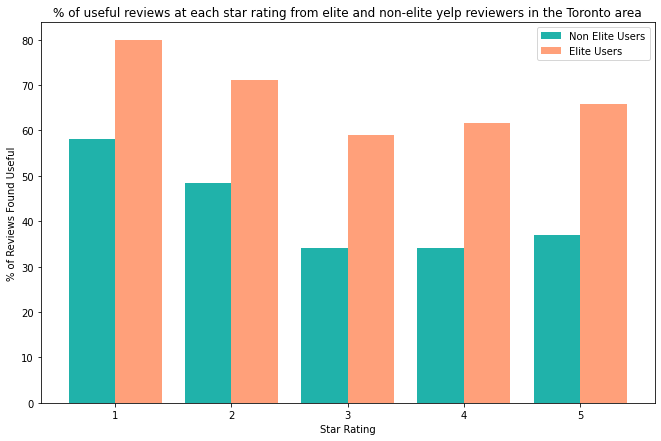

In [20]:
# visualisation of elite/non-elite useful ratings

# sort and calculate non-elite figures

non_elite_useful_ratings = (
  (
      Toronto_revs_rdd
    .filter(lambda x: len(x['elite']) == 0) # filter to 'non-elite' user reviews
  .map(lambda x: [x['stars'], 1]) # map to 'star' rating values and add a numeric field to allow reduce functions
  .reduceByKey(lambda x,y: x+y) # reduce the rdd by the 'star' values and count the occurances of each possibility
  ).join(
    Toronto_revs_rdd
    .filter(lambda x: len(x['elite']) == 0 and x['useful'] > 0) # filter to 'non-elite' user reviews whch have at least one 'useful' tag
  .map(lambda x: [x['stars'], 1]) # map to 'star' rating values and add a numeric field to allow reduce functions
  .reduceByKey(lambda x,y: x+y) # reduce the rdd by the 'star' values and count the occurances of each possibility
  ).map(lambda x: (x[0], x[1][0], x[1][1], (x[1][1]/x[1][0])*100))  # map together the total number of reviews for each star rating, 
                                                                    # the total number of useful reviews at each star rating
                                                                    # and calculate the percentage of useful reviews at each star rating
)

# sort and calculate elite figures

elite_useful_ratings = (
  (
      Toronto_revs_rdd
    .filter(lambda x: len(x['elite']) > 0) # filter to 'elite' user reviews
  .map(lambda x: [x['stars'], 1]) # map to 'star' rating values and add a numeric field to allow reduce functions
  .reduceByKey(lambda x,y: x+y) # reduce the rdd by the 'star' values and count the occurances of each possibility
  ).join(
    Toronto_revs_rdd
    .filter(lambda x: len(x['elite']) > 0 and x['useful'] > 0) # filter to 'non-elite' user reviews whch have at least one 'useful' tag
  .map(lambda x: [x['stars'], 1]) # map to 'star' rating values and add a numeric field to allow reduce functions
  .reduceByKey(lambda x,y: x+y) # reduce the rdd by the 'star' values and count the occurances of each possibility
  ).map(lambda x: (x[0], x[1][0], x[1][1], (x[1][1]/x[1][0])*100))  # map together the total number of reviews for each star rating, 
                                                                    # the total number of useful reviews at each star rating
                                                                    # and calculate the percentage of useful reviews at each star rating
)

# visualise the results

x = non_elite_useful_ratings.map(lambda x: x[0]).collect()
y = non_elite_useful_ratings.map(lambda x: x[3]).collect()
z = elite_useful_ratings.map(lambda x: x[3]).collect()
w = 0.4

fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(111)
plot1 = ax.bar(np.array(x)-(w/2), y, width=w, color='LightSeaGreen', align='center')
plot2 = ax.bar(np.array(x)+(w/2), z, width=w, color='LightSalmon', align='center')
ax.set_title('% of useful reviews at each star rating from elite and non-elite yelp reviewers in the Toronto area')
ax.set_xlabel('Star Rating')
ax.set_ylabel('% of Reviews Found Useful')
ax.legend((plot1[0], plot2[0]), ('Non Elite Users', 'Elite Users'));

Key observations from the data are:
-	Reviews from elite users are found more useful than those by non-elite users across all potential rating values
  - ~30% point increase in the percentage of useful elite user reviews across the board to non-elite users
-	Little difference is seen in the chance of being declared useful for 3, 4 and 5 star reviews
  - ~60% chance for elite users, ~35% chance for non-elite users
-	Even the most useful class of non-elite user reviews (1 star – 58%) has less chance of being found useful that any of the elite user review classes (lowest is 3 star – 60%)
-	Negative reviews (1 and 2 star) are more likely to be classed as useful by other users than other review types for both elite and non-elite reviewers
  -	Extreme negative reviews (1 star) are also more likely to be classed as useful than 2 star
  -	80% of 1 star reviews considered useful for elite users, 58% for non-elite

These observations suggest that other users put far more faith in elite user reviews than those of non-elite users, although caution must be taken as it is possible that having more reviews classed as useful may be one of the criteria to elevate a user to elite status.  It also shows that other users consider reviews concentrating on negative aspects of businesses to be more useful that those that concentrate on good aspects, implying that consumers would rather be warned about negative aspects than recommended good aspects of businesses.


## **Conclusions**

In conclusion we have identified three key observations for business owners in this study:
1.	Elite and non-elite users show different traits in their reviewing behaviour.  Non-elite users are more likely to provide extreme reviews (1 and 5 star) than elite reviewers who tend to be more conservative.
2.	Positive reviews are far more common than negative for both elite and non-elite users.
3.	Users are more likely to find negative reviews more useful than positive and are more likely to find reviews useful from elite users than non-elite.

These observations show that business owners should put more emphasis on reviews from elite users when looking to make changes within their business.  Potential customers appear to put far more focus in the negative aspects of a business, so investment should be made to correct issues that occur rather than to emphasise positive aspects if budgets are limited.  In particular negative reviews from elite users should carry extra weight as they are more reluctant to provide this kind of feedback and other users/potential customers are more likely to find these useful than any other review type.

An important caveat to all the observations made in this study is that it has only been performed for businesses within the Toronto area and work needs to be done to see if this provides a fair representation for businesses in all cities contained within the yelp database.  As suggested earlier investigation into regional or country biases in review data would provide an interesting expansion to this study and also provide additional information to business owners if looking to expand into other areas.
